# PCAP Data Analysis

Compiling some helper functions to help with PCAP Log analysis:

* Convert PCAP to CSV
* Network activity analysis
* Graph theory analysis
* Clustering: One hot encoding, Dimensional Reduction, Clustering

In [55]:
!pip install scapy

In [56]:
# Convert PCAP to CSV

from scapy.all import rdpcap
import csv
import socket
from datetime import datetime

def pcap_to_csv(pcap_file, csv_file):

    # Read the pcap file
    packets = rdpcap(pcap_file)

    # Open CSV file for writing
    with open(csv_file, 'w', newline='') as csvfile:
        # Define CSV writer and headers
        writer = csv.writer(csvfile)
        writer.writerow([
            'Packet_Number',
            'Timestamp',
            'Source_IP',
            'Destination_IP',
            'Protocol',
            'Length',
            'Source_Port',
            'Destination_Port',
            'Flags',
            'Sequence_Number'
        ])

        # Process each packet
        for packet_number, packet in enumerate(packets, 1):
            # Basic packet info
            timestamp = datetime.fromtimestamp(float(packet.time)).strftime('%Y-%m-%d %H:%M:%S.%f')
            length = len(packet)

            # Initialize variables
            src_ip = dst_ip = protocol = src_port = dst_port = flags = seq_num = ''

            # IP layer info
            if packet.haslayer('IP'):
                src_ip = packet['IP'].src
                dst_ip = packet['IP'].dst
                protocol = packet['IP'].proto

            # TCP layer info
            if packet.haslayer('TCP'):
                src_port = packet['TCP'].sport
                dst_port = packet['TCP'].dport
                flags = packet['TCP'].flags
                seq_num = packet['TCP'].seq

            # UDP layer info
            elif packet.haslayer('UDP'):
                src_port = packet['UDP'].sport
                dst_port = packet['UDP'].dport

            # Write packet info to CSV
            writer.writerow([
                packet_number,
                timestamp,
                src_ip,
                dst_ip,
                protocol,
                length,
                src_port,
                dst_port,
                flags,
                seq_num
            ])

def main():
    # Example usage
    input_pcap = "/content/Exercise 1/2024-09-04-traffic-analysis-exercise.pcap"
    output_csv = "/content/Exercise 1/packet_capture.csv"

    try:
        pcap_to_csv(input_pcap, output_csv)
        print(f"Successfully converted {input_pcap} to {output_csv}")
    except Exception as e:
        print(f"Error converting file: {str(e)}")

if __name__ == "__main__":
    main()

Successfully converted /content/Exercise 1/2024-09-04-traffic-analysis-exercise.pcap to /content/Exercise 1/packet_capture.csv


In [57]:
# Run Network Activity Analysis on PCAP

from scapy.all import rdpcap, IP, TCP, UDP, ICMP
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np

class NetworkAnalyzer:
    def __init__(self, pcap_file):
        """Initialize the analyzer with a PCAP file."""
        self.packets = rdpcap(pcap_file)
        self.connections = defaultdict(int)
        self.packet_sizes = []
        self.protocols = []
        self.ip_sources = []
        self.ip_destinations = []
        self.ports = []
        self.timestamps = []

    def analyze_packets(self):
        """Perform basic analysis of all packets."""
        for packet in self.packets:
            # Extract timestamp
            self.timestamps.append(datetime.fromtimestamp(float(packet.time)))

            # Analyze IP layer
            if IP in packet:
                self.ip_sources.append(packet[IP].src)
                self.ip_destinations.append(packet[IP].dst)
                self.protocols.append(packet[IP].proto)
                self.packet_sizes.append(len(packet))

                # Track unique connections
                connection = (packet[IP].src, packet[IP].dst)
                self.connections[connection] += 1

                # Analyze TCP/UDP ports
                if TCP in packet:
                    self.ports.extend([packet[TCP].sport, packet[TCP].dport])
                elif UDP in packet:
                    self.ports.extend([packet[UDP].sport, packet[UDP].dport])

    def get_basic_stats(self):
        """Return basic statistics about the capture."""
        return {
            'total_packets': len(self.packets),
            'unique_ips': len(set(self.ip_sources + self.ip_destinations)),
            'unique_connections': len(self.connections),
            'avg_packet_size': np.mean(self.packet_sizes) if self.packet_sizes else 0,
            'duration_seconds': (max(self.timestamps) - min(self.timestamps)).total_seconds() if self.timestamps else 0
        }

    def get_top_talkers(self, n=10):
        """Identify the most active IP addresses."""
        source_counts = Counter(self.ip_sources)
        dest_counts = Counter(self.ip_destinations)

        return {
            'top_sources': dict(source_counts.most_common(n)),
            'top_destinations': dict(dest_counts.most_common(n))
        }

    def get_protocol_distribution(self):
        """Analyze protocol distribution."""
        protocol_map = {1: 'ICMP', 6: 'TCP', 17: 'UDP'}
        protocol_counts = Counter(self.protocols)
        return {protocol_map.get(proto, f'Unknown ({proto})'): count
                for proto, count in protocol_counts.items()}

    def analyze_port_usage(self, n=10):
        """Analyze most commonly used ports."""
        port_counts = Counter(self.ports)
        common_ports = {
            20: 'FTP-DATA', 21: 'FTP', 22: 'SSH', 23: 'TELNET',
            25: 'SMTP', 53: 'DNS', 80: 'HTTP', 443: 'HTTPS'
        }

        top_ports = {}
        for port, count in port_counts.most_common(n):
            service = common_ports.get(port, f'PORT-{port}')
            top_ports[f"{port} ({service})"] = count
        return top_ports

    def detect_potential_anomalies(self):
        """Basic anomaly detection."""
        anomalies = []

        # Check for potential port scans
        port_per_ip = defaultdict(set)
        for i, packet in enumerate(self.packets):
            if TCP in packet:
                port_per_ip[packet[IP].src].add(packet[TCP].dport)

        for ip, ports in port_per_ip.items():
            if len(ports) > 100:  # Threshold for potential port scan
                anomalies.append(f"Potential port scan from {ip} ({len(ports)} ports)")

        # Check for potential DOS attacks
        for connection, count in self.connections.items():
            if count > 1000:  # Threshold for potential DOS
                anomalies.append(f"High traffic volume between {connection[0]} and {connection[1]}")

        return anomalies

    def generate_time_series(self):
        """Generate time series data of packet counts."""
        df = pd.DataFrame({'timestamp': self.timestamps})
        df['count'] = 1
        return df.set_index('timestamp').resample('1min').count()

    def save_analysis_report(self, output_file):
        """Save a comprehensive analysis report."""
        with open(output_file, 'w') as f:
            # Basic Stats
            stats = self.get_basic_stats()
            f.write("=== Network Traffic Analysis Report ===\n\n")
            f.write("Basic Statistics:\n")
            for key, value in stats.items():
                f.write(f"{key}: {value}\n")

            # Top Talkers
            f.write("\nTop Talkers:\n")
            talkers = self.get_top_talkers()
            f.write("\nTop Source IPs:\n")
            for ip, count in talkers['top_sources'].items():
                f.write(f"{ip}: {count} packets\n")

            # Protocol Distribution
            f.write("\nProtocol Distribution:\n")
            for proto, count in self.get_protocol_distribution().items():
                f.write(f"{proto}: {count} packets\n")

            # Port Analysis
            f.write("\nMost Used Ports:\n")
            for port, count in self.analyze_port_usage().items():
                f.write(f"{port}: {count} occurrences\n")

            # Anomalies
            f.write("\nPotential Anomalies:\n")
            for anomaly in self.detect_potential_anomalies():
                f.write(f"- {anomaly}\n")

def main():
    # Example usage
    pcap_file = "/content/Exercise 1/2024-09-04-traffic-analysis-exercise.pcap"
    analyzer = NetworkAnalyzer(pcap_file)

    try:
        # Perform analysis
        analyzer.analyze_packets()

        # Generate and save report
        analyzer.save_analysis_report("/content/Exercise 1/packet_analysis.txt")

        # Print basic stats
        print("Analysis complete! Basic statistics:")
        for key, value in analyzer.get_basic_stats().items():
            print(f"{key}: {value}")

        # Print potential anomalies
        print("\nPotential anomalies detected:")
        for anomaly in analyzer.detect_potential_anomalies():
            print(f"- {anomaly}")

    except Exception as e:
        print(f"Error analyzing capture: {str(e)}")

if __name__ == "__main__":
    main()

Analysis complete! Basic statistics:
total_packets: 5091
unique_ips: 42
unique_connections: 77
avg_packet_size: 423.1392537002293
duration_seconds: 3576.159984

Potential anomalies detected:


In [59]:
# Run Graph Theory Analysis on PCAP

import networkx as nx
from scapy.all import rdpcap, IP, TCP, UDP
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import community
import numpy as np
from datetime import datetime

class NetworkGraphAnalyzer:
    def __init__(self, pcap_file):
        """Initialize the analyzer with a PCAP file."""
        self.packets = rdpcap(pcap_file)
        self.G = nx.Graph()
        self.directed_G = nx.DiGraph()
        self.edge_weights = defaultdict(int)
        self.node_weights = defaultdict(int)
        self.protocols = defaultdict(int)

    def build_graph(self):
        """Build network graphs from PCAP data."""
        for packet in self.packets:
            if IP in packet:
                src = packet[IP].src
                dst = packet[IP].dst

                # Add nodes and edges to both directed and undirected graphs
                self.G.add_edge(src, dst)
                self.directed_G.add_edge(src, dst)

                # Track edge weights (connection frequency)
                self.edge_weights[(src, dst)] += 1

                # Track node weights (packet counts)
                self.node_weights[src] += 1
                self.node_weights[dst] += 1

                # Track protocols
                if TCP in packet:
                    self.protocols['TCP'] += 1
                elif UDP in packet:
                    self.protocols['UDP'] += 1
                else:
                    self.protocols['Other'] += 1

        # Add weights to graph edges
        for (src, dst), weight in self.edge_weights.items():
            self.G[src][dst]['weight'] = weight
            self.directed_G[src][dst]['weight'] = weight

    def analyze_centrality(self):
        """Calculate various centrality metrics."""
        metrics = {
            'degree': nx.degree_centrality(self.G),
            'betweenness': nx.betweenness_centrality(self.G),
            'eigenvector': nx.eigenvector_centrality(self.G, max_iter=1000),
            'pagerank': nx.pagerank(self.directed_G)
        }

        # Convert to DataFrame for easier analysis
        df = pd.DataFrame(metrics)
        return df.sort_values('degree', ascending=False)

    def detect_communities(self):
        """Detect network communities using the Louvain method."""
        # First pass
        communities = community.best_partition(self.G)

        # Group nodes by community
        community_groups = defaultdict(list)
        for node, community_id in communities.items():
            community_groups[community_id].append(node)

        return community_groups

    def calculate_graph_metrics(self):
        """Calculate various graph-level metrics."""
        return {
            'nodes': self.G.number_of_nodes(),
            'edges': self.G.number_of_edges(),
            'density': nx.density(self.G),
            'avg_clustering': nx.average_clustering(self.G),
            'avg_shortest_path': nx.average_shortest_path_length(self.G) if nx.is_connected(self.G) else float('inf'),
            'diameter': nx.diameter(self.G) if nx.is_connected(self.G) else float('inf'),
            'avg_degree': sum(dict(self.G.degree()).values()) / self.G.number_of_nodes()
        }

    def identify_important_nodes(self, top_n=10):
        """Identify important nodes using various metrics."""
        # Calculate different centrality measures
        degree_cent = nx.degree_centrality(self.G)
        between_cent = nx.betweenness_centrality(self.G)
        eigen_cent = nx.eigenvector_centrality(self.G, max_iter=1000)

        # Combine metrics
        important_nodes = defaultdict(dict)
        for node in self.G.nodes():
            important_nodes[node] = {
                'degree_centrality': degree_cent[node],
                'betweenness_centrality': between_cent[node],
                'eigenvector_centrality': eigen_cent[node],
                'total_packets': self.node_weights[node]
            }

        # Convert to DataFrame and sort
        df = pd.DataFrame(important_nodes).T
        df['importance_score'] = df.mean(axis=1)
        return df.sort_values('importance_score', ascending=False).head(top_n)

    def visualize_network(self, output_file=None, show_labels=True):
        """Create a visualization of the network."""
        plt.figure(figsize=(15, 10))

        # Calculate node sizes based on degree
        node_sizes = [v * 100 for v in dict(self.G.degree()).values()]

        # Calculate edge weights for thickness
        edge_weights = [self.G[u][v].get('weight', 1) for u, v in self.G.edges()]

        # Use spring layout for visualization
        pos = nx.spring_layout(self.G, k=1/np.sqrt(len(self.G.nodes())), iterations=50)

        # Draw the network
        nx.draw_networkx_edges(self.G, pos, alpha=0.2,
                             width=[np.log(w) for w in edge_weights])
        nx.draw_networkx_nodes(self.G, pos, node_size=node_sizes,
                             node_color=list(dict(self.G.degree()).values()),
                             cmap=plt.cm.viridis)

        if show_labels:
            nx.draw_networkx_labels(self.G, pos, font_size=8)

        plt.title("Network Graph Visualization")
        plt.axis('off')

        if output_file:
            plt.savefig(output_file)
        else:
            plt.show()

        plt.close()

    def generate_report(self, output_file):
        """Generate a comprehensive analysis report."""
        with open(output_file, 'w') as f:
            f.write("=== Network Graph Analysis Report ===\n\n")

            # Basic metrics
            f.write("Basic Graph Metrics:\n")
            metrics = self.calculate_graph_metrics()
            for metric, value in metrics.items():
                f.write(f"{metric}: {value}\n")

            # Protocol distribution
            f.write("\nProtocol Distribution:\n")
            total_packets = sum(self.protocols.values())
            for protocol, count in self.protocols.items():
                percentage = (count / total_packets) * 100
                f.write(f"{protocol}: {count} packets ({percentage:.2f}%)\n")

            # Important nodes
            f.write("\nMost Important Nodes:\n")
            important_nodes = self.identify_important_nodes()
            f.write(important_nodes.to_string())

            # Community detection
            f.write("\n\nCommunity Detection:\n")
            communities = self.detect_communities()
            for community_id, nodes in communities.items():
                f.write(f"\nCommunity {community_id}: {len(nodes)} nodes")
                f.write(f"\nNodes: {', '.join(nodes[:10])}...")

def main():
    # Example usage
    pcap_file = "/content/Exercise 1/2024-09-04-traffic-analysis-exercise.pcap"
    analyzer = NetworkGraphAnalyzer(pcap_file)

    try:
        # Build and analyze the network
        print("Building network graph...")
        analyzer.build_graph()

        # Generate visualization
        print("Generating network visualization...")
        analyzer.visualize_network("/content/Exercise 1/network_graph.png")

        # Generate report
        print("Generating analysis report...")
        analyzer.generate_report("/content/Exercise 1/network_analysis_report.txt")

        # Print some basic metrics
        print("\nBasic network metrics:")
        metrics = analyzer.calculate_graph_metrics()
        for metric, value in metrics.items():
            print(f"{metric}: {value}")

        # Print top important nodes
        print("\nMost important nodes:")
        print(analyzer.identify_important_nodes(top_n=5))

    except Exception as e:
        print(f"Error analyzing network: {str(e)}")

if __name__ == "__main__":
    main()

Building network graph...
Generating network visualization...
Generating analysis report...

Basic network metrics:
nodes: 42
edges: 41
density: 0.047619047619047616
avg_clustering: 0.0
avg_shortest_path: 2.085946573751452
diameter: 4
avg_degree: 1.9523809523809523

Most important nodes:
               degree_centrality  betweenness_centrality  \
172.17.0.99              0.95122                0.996341   
172.17.0.17              0.04878                0.095122   
46.254.34.201            0.02439                0.000000   
79.124.78.197            0.02439                0.000000   
23.45.119.144            0.02439                0.000000   

               eigenvector_centrality  total_packets  importance_score  
172.17.0.99                  0.706847         4793.0       1198.913602  
172.17.0.17                  0.116203         1310.0        327.565026  
46.254.34.201                0.113148          782.0        195.534384  
79.124.78.197                0.113148          591.0      

In [60]:
# Encode PCAP into one-hot-dummy variables

# import libraries
import numpy as np
import pandas as pd

# import the data required
data = pd.read_csv('/content/Exercise 1/packet_capture.csv')
# print(data.head())

# Get dummies
one_hot_encoded_data = pd.get_dummies(data, columns = ['Source_IP', 'Destination_IP', 'Protocol', 'Source_Port', 'Destination_Port'], dtype=int)
# print(one_hot_encoded_data)

one_hot_encoded_data.to_csv('/content/Exercise 1/encoded_data.csv', index=False)

In [ ]:
# Perform Dimensional Reduction

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA


In [61]:
# Load dataset
dataset = pd.read_csv('/content/Exercise 1/encoded_data.csv')
features = dataset.drop(['Packet_Number', 'Timestamp', 'Length', 'Flags', 'Sequence_Number'], axis = 1)
features.to_csv('/content/Exercise 1/features.csv', index=False)

In [62]:
# Model parameters
model = PCA(n_components = 2)
model.fit(features)

PCA(n_components=2)

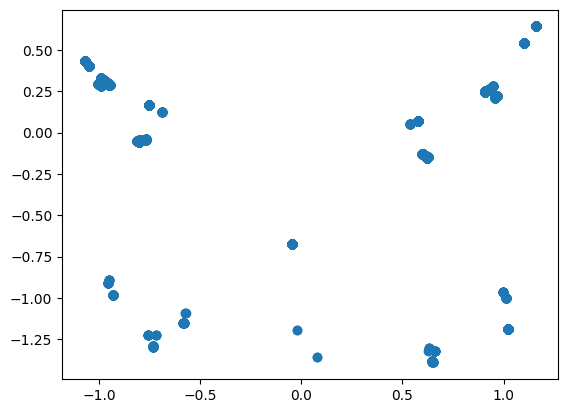

In [63]:
# Predict latent space
pred = model.transform(features)

# Plot clusters
x_plot = pd.DataFrame(pred)[0]
y_plot = pd.DataFrame(pred)[1]
#plt.scatter(x_plot, y_plot, c=labels)
plt.scatter(x_plot, y_plot)
plt.show()

In [64]:
# Produce File for Clustering

clustered = pd.concat([one_hot_encoded_data, pd.DataFrame(pred, columns=['x_pos', 'y_pos'])], axis=1)
clustered.to_csv('/content/Exercise 1/xy.csv')

In [65]:
# Run Clustering

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [66]:
# Load dataset
dataset = pd.read_csv('/content/Exercise 1/xy.csv')
locations = dataset[['x_pos', 'y_pos']].values
labels = dataset[['Packet_Number']].values

In [67]:
# KMeans Clustering

def getscore(x, y):
    km = KMeans(n_clusters=x)
    km.fit(y)
    return 'Score for ' + str(x) + ' clusters: ' + str(silhouette_score(km.fit_transform(y), km.labels_))

def getscores(x):
    response = []
    for i in range(2,11):
        response.append(getscore(i, x))
    return pd.DataFrame(response, columns=['outcomes'])

In [68]:
# Test score for clusters
getscores(locations)

,outcomes
0,Score for 2 clusters: 0.724321515678171
1,Score for 3 clusters: 0.709055996150876
2,Score for 4 clusters: 0.7294006303306123
3,Score for 5 clusters: 0.730008155558609
4,Score for 6 clusters: 0.7462586214952734
5,Score for 7 clusters: 0.784399616690992
6,Score for 8 clusters: 0.8457623369157797
7,Score for 9 clusters: 0.8443251091897161
8,Score for 10 clusters: 0.8630549640017995


In [69]:
# Model parameters
model = KMeans(n_clusters = 10, random_state = 0)

In [70]:
# Fit model

model.fit(locations)

KMeans(n_clusters=10, random_state=0)

In [71]:
# Predictions

pred = model.predict(locations)

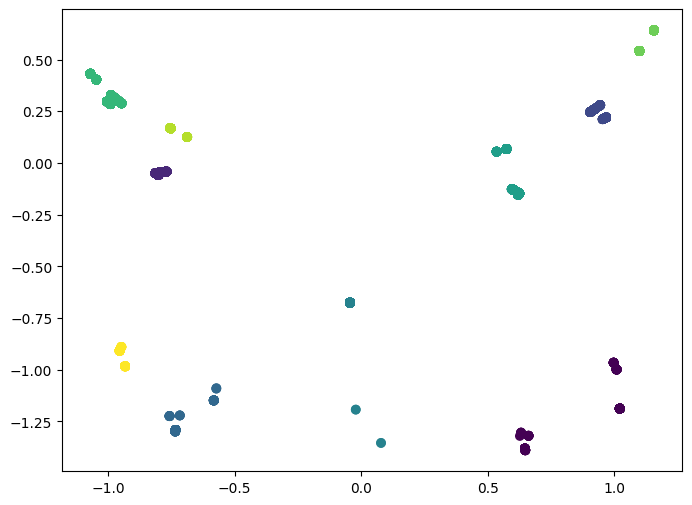

In [72]:
# Plot clusters
x_plot = pd.DataFrame(locations)[0]
y_plot = pd.DataFrame(locations)[1]
label_plot = pd.DataFrame(labels)
plt.figure(figsize=(8,6))
plt.scatter(x_plot, y_plot, c=pred)
'''
for i, txt in enumerate(label_plot[0]):
    plt.annotate(txt, (x_plot[i], y_plot[i]))
'''
plt.show()

In [74]:
packet = pd.read_csv('/content/Exercise 1/packet_capture.csv')
clustered = pd.concat([packet, pd.DataFrame(pred, columns=['cluster'])], axis=1)
clustered.to_csv('/content/Exercise 1/clustered.csv')